<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction with Cluster Variables and selected Weather Variables (according to Feature importance)

## Import the Data & Modules

In [1]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance


# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data

In [2]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [3]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYears.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYears.csv", encoding="utf-8") #2020 prediction df
queen_clusters = pd.read_csv("../Feeder_years/WBds_CLUSTERSnests.csv",sep=",")
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

## Further Clean the Data

In [4]:
# Adding cluster labels

queen_train = pd.merge(queen_train, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')
queen_predict = pd.merge(queen_predict, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')

In [5]:
# Remove the Municipalities to which we did not assign a Cluster, since there was not reliable data for us to predict 

queen_train = queen_train.loc[~queen_train.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:].copy()
queen_predict = queen_predict.loc[~queen_predict.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:].copy()

## Get the Prediction for: Cluster 1 

### Arrange data into a features matrix and target vector

In [6]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y = queen_train.NESTS

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train.iloc[:,6:-10].drop(["station_code"],axis=1).copy()
X["cluster"] = queen_train.Cluster.copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020 = queen_predict.iloc[:,6:-10].drop("station_code",axis=1).copy()
queen_predict2020["cluster"] = queen_predict.Cluster.copy()

Check if the shape of the features and their labels match or if there are errors raised

In [7]:
# Perform checks of features labels & their shapes

assert queen_predict2020.shape[1] == X.shape[1], "Error: Number of columns do not match!"
assert (queen_predict2020.columns == X.columns).any(), "Error: Columns labels do not match"
assert y.shape == (212,), "Error: y shape is incorrect!"

### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [8]:
# Scale the datasets using MinMaxScaler

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns=X.columns) # create a Pandas Dataframe == X

#### Choose a class of model by importing the appropriate estimator class

In [9]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [10]:
# selecting the XGBoost model and fitting with the train data for each cluster

model.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

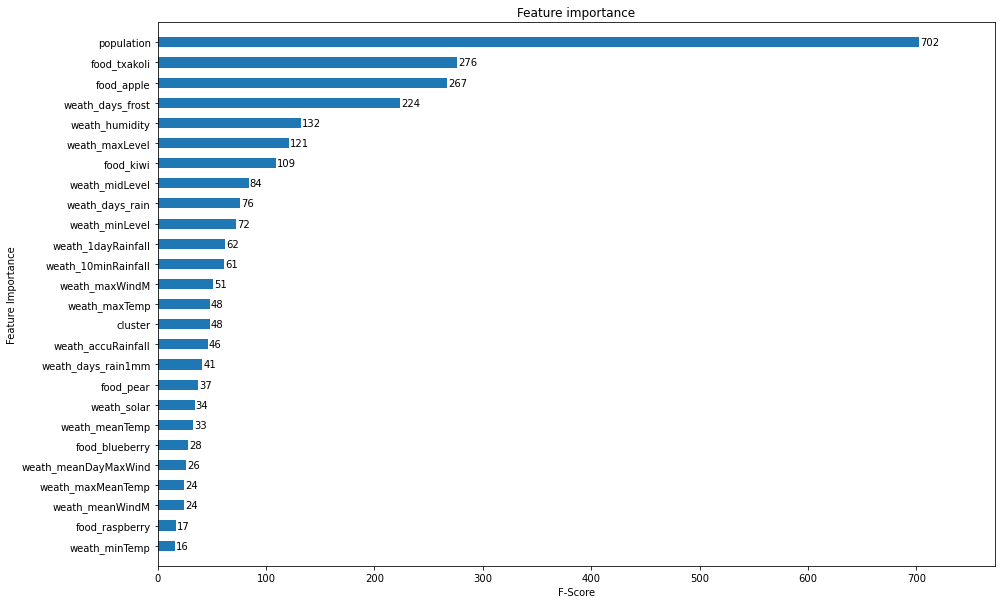

In [11]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

In [19]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables

X = queen_train.loc[:,["population","food_txakoli","food_apple","weath_days_frost","weath_humidity","weath_maxLevel","food_kiwi","Cluster"]].copy()

queen_predict2020 = queen_predict.loc[:,["population","food_txakoli","food_apple","weath_days_frost","weath_humidity","weath_maxLevel","food_kiwi","Cluster"]].copy()

### Choose a class of model by importing the appropriate estimator class

In [20]:
# selecting the XGBoost model and fitting with the train data

model = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [21]:
# refitting the model

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [22]:
# make a prediction

prediction_2020 = model.predict(queen_predict2020)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [23]:
# Create a new Column with the 2020 prediction
queen_predict["nests_2020"] = prediction_2020

In [24]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48022, 48071, 48088, 48074, 48051, 48020],\
             "NOMBRE MUNICIPIO":["Karrantza Harana/Valle de Carranza","Muskiz","Ubide","Urduña/Orduña","Lanestosa","Bilbao"],\
             "NIDOS 2020":[0,0,0,0,0,0]})

In [26]:
queen_predict

,municip_name_x,municip_code,year_offset,NESTS,colonies_amount,food_fruit,food_apple,food_txakoli,food_kiwi,food_pear,...,cluster_cosmo,cluster_survive,cluster_food,cluster_weather_wet,cluster_weather_temp,cluster_weather_wind,cluster_weather_level,municip_name_y,Cluster,nests_2020
0,Abadiño,48001,2019,0,160.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,1,Abadiño,2.0,24.071241
1,Abanto y Ciérvana-Abanto Zierbena,48002,2019,0,161.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,1,1,1,1,Abanto y Ciérvana-Abanto Zierbena,2.0,60.359745
2,Ajangiz,48911,2019,0,0.0,17.0,1.0,3.0,15.0,0.0,...,0,0,0,1,1,0,1,Ajangiz,0.0,18.158953
3,Alonsotegi,48912,2019,0,200.0,7.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,Alonsotegi,0.0,18.497873
4,Amorebieta-Etxano,48003,2019,0,267.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,1,Amorebieta-Etxano,1.0,89.617279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Zaratamo,48097,2019,0,0.0,8.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,1,Zaratamo,2.0,28.519577
108,Zeanuri,48024,2019,0,15.0,64.0,5.0,2.0,3.0,0.0,...,0,0,0,1,0,0,1,Zeanuri,0.0,22.899723
109,Zeberio,48025,2019,0,0.0,70.0,5.0,5.0,1.0,0.0,...,0,0,0,0,0,1,1,Zeberio,0.0,17.081467
110,Zierbena,48913,2019,0,0.0,13.0,0.0,0.0,4.0,0.0,...,0,0,0,0,1,1,1,Zierbena,0.0,12.457030


In [27]:
HEX = queen_predict.loc[:,["municip_code","municip_name_x","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [28]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2752


'All Municipality Names and Codes to be submitted match the Template'

In [29]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [ ]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210519_XGyears_cluster_var.csv", index=False)